In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DEBT_control_class import DEBT_Control_Protocol
import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


In [2]:
def cyclic_example_generate_params():
    n = 3
    params = dict()
    params["custom"] = True
    params["capacity_matrix"] = np.array([[0, 100, 100], [100, 0, 100], [100, 100, 0]])

    params["custom_routes"] = True
    paths = dict()
    empty_path = np.zeros((3, 3))
    paths[(0,1)] = [empty_path.copy(), empty_path.copy()]
    paths[(0,1)][0][0,1] = 1
    paths[(0,1)][1][0,2] = 1
    paths[(0,1)][1][2,1] = 1
    paths[(1,2)] = [empty_path.copy(), empty_path.copy()]
    paths[(1,2)][0][1,2] = 1
    paths[(1,2)][1][1,0] = 1
    paths[(1,2)][1][0,2] = 1
    paths[(2,0)] = [empty_path.copy(), empty_path.copy()]
    paths[(2,0)][0][2,0] = 1
    paths[(2,0)][1][2,1] = 1
    paths[(2,0)][1][1,0] = 1
    params["routes"] = paths

    demand_params = dict()
    demand_params["custom demands"] = True
    demand_params["demand_matrix"] = np.array([[0, 10, 0], [0, 0, 10], [10, 0, 0]])
    demand_params["distribution"] = "deterministic"
    return params, demand_params, n

In [3]:
def deadlock_example_generate_params():
    n = 3
    params = dict()
    params["custom"] = True
    params["capacity_matrix"] = np.array([[0, 100, 0], [100, 0, 100], [0, 100, 0]])

    params["custom_routes"] = True
    paths = dict()
    empty_path = np.zeros((3, 3))
    paths[(0,2)] = [empty_path.copy()]
    paths[(0,2)][0][0,1] = 1
    paths[(0,2)][0][1,2] = 1
    paths[(2,0)] = [empty_path.copy()]
    paths[(2,0)][0][2,1] = 1
    paths[(2,0)][0][1,0] = 1
    paths[(1,2)] = [empty_path.copy()]
    paths[(1,2)][0][1,2] = 1
    paths[(1,0)] = [empty_path.copy()]
    paths[(1,0)][0][1,0] = 1
    params["routes"] = paths

    demand_params = dict()
    demand_params["custom demands"] = True
    demand_params["demand_matrix"] = np.array([[0, 0, 10], [10, 0, 10], [10, 0, 0]])
    demand_params["distribution"] = "deterministic"
    return params, demand_params, n

In [89]:
params, demand_params, n = cyclic_example_generate_params()
price_params = dict()
price_params["stepsize"] = 0.01
price_params["threshold"] = 1*np.ones((n,n))
price_params["sensitivity"] = 0.0*np.ones((n,n)) # regularizer coefficient

In [90]:
# initialize the PCN and the protocol
myPCN = DEBT_Control_Protocol(params, demand_params, price_params) 
# loop for T time steps
T = 21

In [91]:
# create arrays to store flows and prices
flows_data = dict()
path_price_data = dict()
for i in range(n):
    for j in range(n):
        if (i,j) not in myPCN.paths.keys():
            continue
        flows_data[(i,j)] = np.zeros((T,len(myPCN.paths[(i,j)])))
        path_price_data[(i,j)] = np.zeros((T,len(myPCN.paths[(i,j)])))
edge_price_data = np.zeros((T, n, n))
reset_data = np.zeros((T, n, n))

In [92]:
logging.info("starting loop with %d iterations", T)
for t in range(T):
    logging.info("starting step %d", t)
    myPCN.single_step(t)
    edge_price_data[t] = myPCN.channel_prices.copy()
    for key in flows_data.keys():
        flows_data[key][t] = myPCN.flow_requests[key]
        path_price_data[key][t] = myPCN.path_prices[key]
        reset_data[t] = myPCN.channels_reset


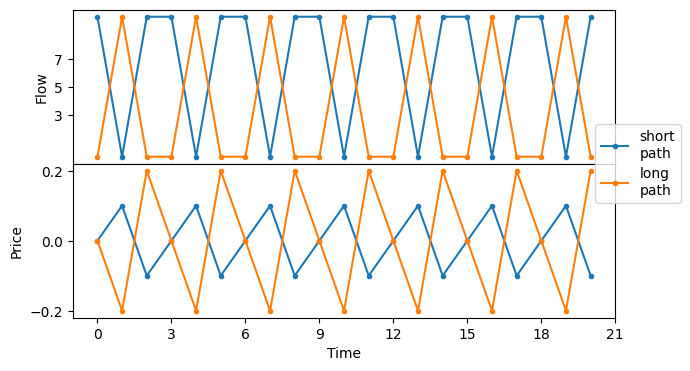

In [93]:
fig = plt.figure(figsize = (7,4))
# gs = fig.add_gridspec(2, hspace=0)
axs = fig.subplots(2, sharex=True)
plt.subplots_adjust(hspace=0)
i = 0
j = 1
axs[0].plot(flows_data[(i,j)][:,0], label = "short\npath", marker ='.')
axs[0].plot(flows_data[(i,j)][:,1], label = "long\npath", marker ='.')
axs[1].plot(path_price_data[(i,j)][:,0], label = "short\npath", marker ='.')
axs[1].plot(path_price_data[(i,j)][:,1], label = "long\npath", marker ='.')
plt.legend(bbox_to_anchor=(0.95, 1.3), loc="upper left")
plt.xticks(range(0, T+1, 3))
axs[0].set(yticks = range(3, 8, 2))
axs[1].set(yticks = [-0.2, 0, 0.2])
axs[0].set(ylabel='Flow')
axs[1].set(xlabel = 'Time', ylabel='Price')
# axs[0].grid(True, axis='x')
# axs[1].grid(True, axis='x')
# fig.tight_layout()
fig.savefig("cyclic_example.pdf")

KeyError: (0, 2)

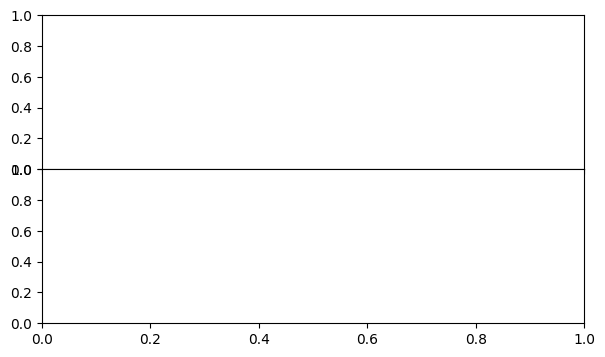

In [94]:
fig = plt.figure(figsize = (7,4))
# gs = fig.add_gridspec(2, hspace=0)
axs = fig.subplots(2, sharex=True)
plt.subplots_adjust(hspace=0)
i = 0
j = 2
axs[0].plot(flows_data[(i,j)][:,0], label = "A -> C", marker ='.')
axs[0].plot(flows_data[(i+1,j)][:,0], label = "B -> C", marker ='.')
axs[1].plot(path_price_data[(i,j)][:,0], label = "A -> C", marker ='.')
axs[1].plot(path_price_data[(i+1,j)][:,0], label = "B -> C", marker ='.')
plt.legend(bbox_to_anchor=(0, 1.2), loc="upper left")
plt.xticks(range(0, 51, 5))
axs[0].set(yticks = range(0, 11, 5))
axs[1].set(yticks = [0, 1])
axs[0].set(ylabel='Flow')
axs[1].set(xlabel = 'Time', ylabel='Price')
# axs[0].grid(True, axis='x')
# axs[1].grid(True, axis='x')
# fig.tight_layout()
fig.savefig("deadlock_example.pdf")

Text(0.5, 1.0, 'Flows as a function of time')

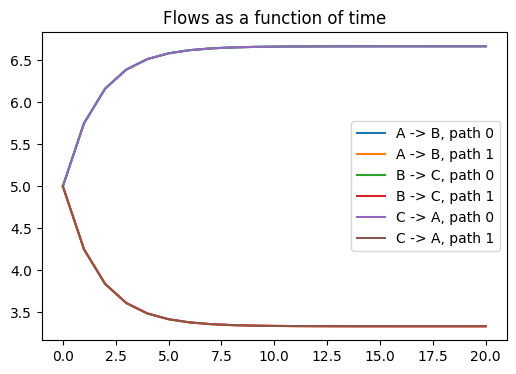

In [ ]:
alphabets = ['A', 'B', 'C', 'D', 'E', 'F']
plt.close("all")
plt.figure(figsize=(6,4))
for i in range(n):
    for j in range(n):
        if myPCN.demands[i,j] > 0:
            for k in range(len(myPCN.paths[(i,j)])):
                plt.plot(flows_data[(i,j)][:,k], label = alphabets[i] + " -> " + alphabets[j] + ", path " + str(k))
plt.legend()
plt.title("Flows as a function of time")

Text(0.5, 1.0, 'Prices as a function of time')

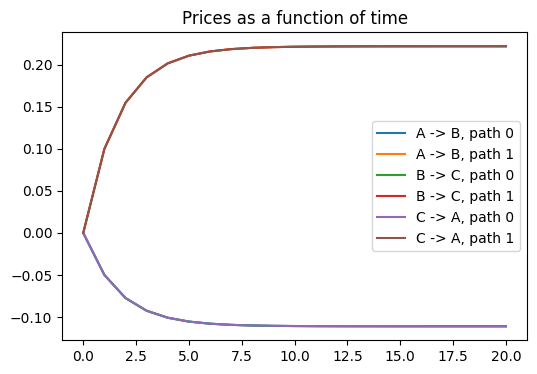

In [ ]:
plt.figure(figsize=(6,4))
for i in range(n):
    for j in range(n):
        if myPCN.demands[i,j] > 0:
            for k in range(len(myPCN.paths[(i,j)])):
                plt.plot(path_price_data[(i,j)][:,k], label = alphabets[i] + " -> " + alphabets[j] + ", path " + str(k))
plt.legend()
plt.title("Prices as a function of time")